In [7]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from rdkit import Chem
import numpy as np
import mols2grid
from rdkit.Chem import QED
import glob

import mols2grid
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs

from sklearn.utils import compute_sample_weight
import numpy as np
from collections import Counter
from rdkit.Chem import QED
import scikit_posthocs as sp
from tqdm.auto import tqdm
import json
import joblib

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs

from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from rdkit import Chem
from rdkit.Chem import Draw

In [6]:
!pip install torch

  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 886.1 kB/s  0:17:55 eta 0:00:010:00:27
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 843.6 kB/s  0:11:27 eta 0:00:010:00:20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 913.5 kB/s  0:00:11 eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 749.3 kB/s  0:01:55 eta 0:00:010:00:03
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 1.0 MB/s  0:00:00m 1.0 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 631.2 kB/s  0:13:50 eta 0:00:010:00:20
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 867.0 kB/s  0:03:52 eta 0:00:010:00:06
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.1 MB/s  0:00:011.2 MB/s eta 0:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 625.1 kB/s  0:01:31 eta 0:00:010:00:03


In [ ]:
X_train = pd.read_parquet(r'x_train_6618') # I have deleted all _5k s, e.g. X_train_5k to X_train
y_train = pd.read_csv(r'y_train_6618.csv')
descriptors = list(X_train.columns)
# optimized hyperparameters
with open(r'optuna_results_6618.json', 'r') as file:
    hyperparameters = json.load(file)
best_params_dict = {
    model: {'best_params': values['best_params']}
    for model, values in hyperparameters.items()
}    
    

In [4]:
X_test =  pd.read_parquet(r'x_test_6618')
y_test = pd.read_csv(r'y_test_6618.csv')

In [5]:
initial_data = pd.read_csv(r'5k data small molecules and drugs.csv', index_col =0)
y_train['phase'] = y_train['phase'].apply(lambda x: int(x/4))
y_test['phase'] = y_test['phase'].apply(lambda x: int(x/4))


In [6]:
SMILES_train_set = list(initial_data.iloc[X_train.index]['SMILES'])
SMILES_test_set = list(initial_data.iloc[X_test.index]['SMILES'])


Dataset analysis

In [7]:
# Convert RDKit fingerprint to binary numpy array
def fp_to_array(fp):
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

# Generate all fingerprints and convert to bit arrays
def get_fp_matrix(molecules):
    fps = [get_maccs_fingerprint(mol) for mol in molecules]
    bit_vectors = np.array([fp_to_array(fp) for fp in fps], dtype=np.float32)
    return bit_vectors

# Generate MACCS keys fingerprint
def get_maccs_fingerprint(mol):
    return AllChem.GetMACCSKeysFingerprint(mol)

# Compute pairwise Tanimoto similarity using PyTorch on GPU
def compute_tanimoto_gpu(fp_matrix_np):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X = torch.tensor(fp_matrix_np, device=device)
    dot_product = torch.mm(X, X.T)
    sum_x = X.sum(dim=1).view(-1, 1)
    denominator = sum_x + sum_x.T - dot_product
    similarity = dot_product / denominator.clamp(min=1e-6)
    return similarity.cpu().numpy()

# Compute average similarity from upper triangle
def average_tanimoto_similarity(sim_matrix):
    upper_indices = np.triu_indices_from(sim_matrix, k=1)
    return np.mean(sim_matrix[upper_indices])

# Plot and save similarity heatmap
def plot_similarity_heatmap(similarity_matrix, filename=None):
    similarity_df = pd.DataFrame(similarity_matrix)
    
    # Set font to Arial or try other one
    # plt.rcParams['font.family'] = 'Arial'
    # sns.set(font='Arial')

    # Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(similarity_df, annot=False, cmap="coolwarm", cbar_kws={'label': 'Tanimoto Similarity'})

    # Save as TIFF image (if filename is provided)
    if filename:
        plt.savefig(filename, format='tiff', dpi=300, bbox_inches='tight')

    # Display the plot
    plt.show()

# Main function to process SMILES and visualize the results
def process_and_visualize_smiles(smiles_set, output_filename=None):
    molecules = [Chem.MolFromSmiles(smi) for smi in smiles_set]
    fp_matrix_np = get_fp_matrix(molecules)
    
    # Compute Similarity Matrix on GPU
    similarity_matrix = compute_tanimoto_gpu(fp_matrix_np)
    
    # Plot and optionally save the heatmap
    plot_similarity_heatmap(similarity_matrix, output_filename)
    
    # Print Mean Similarity
    print("Mean Tanimoto similarity:", average_tanimoto_similarity(similarity_matrix))

In [8]:
phase_data = pd.read_csv(r'Clinical candidates dataset.csv')


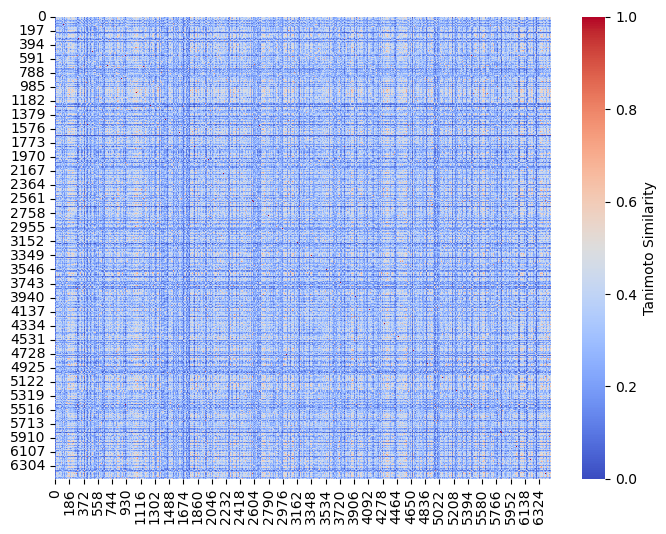

Mean Tanimoto similarity: 0.30911818


In [9]:
process_and_visualize_smiles(SMILES_train_set)
#process_and_visualize_smiles(SMILES_test_set)
#process_and_visualize_smiles(phase_data[phase_data['phase']==3]['SMILES'])
#process_and_visualize_smiles(phase_data[phase_data['phase']==2]['SMILES'])
#process_and_visualize_smiles(phase_data[phase_data['phase']==1]['SMILES'])

In [10]:
def get_scaffold_smiles(mol):
    """Return the canonical SMILES of the Murcko scaffold for a molecule."""
    scaffold = MurckoScaffold.GetScaffoldForMol(mol)
    if scaffold is not None:
        return Chem.MolToSmiles(scaffold, isomericSmiles=True)
    else:
        return None

def calculate_scaffold_frequencies(molecules):
    """Calculate frequencies of scaffolds in a list of molecules."""
    scaffold_smiles = []
    for mol in molecules:
        if mol is not None:
            smi = get_scaffold_smiles(mol)
            if smi:
                scaffold_smiles.append(smi)
    return Counter(scaffold_smiles)


In [11]:
#example of scaffold frequency calculation for trainning set molecules
calculate_scaffold_frequencies([Chem.MolFromSmiles(smi) for smi in SMILES_train_set])

Counter({'c1ccccc1': 830,
         'c1ccncc1': 102,
         'c1ccc2ccccc2c1': 39,
         'C1CCNCC1': 36,
         'c1ccc2ncccc2c1': 34,
         'c1ccc2[nH]ccc2c1': 31,
         'C1CCNC1': 31,
         'C1CCCCC1': 19,
         'C1CNCCN1': 15,
         'c1c[nH]cn1': 15,
         'O=c1ccc2ccccc2o1': 14,
         'C1CCOC1': 14,
         'c1ccc(Cc2ccccc2)cc1': 13,
         'C1CCCC1': 13,
         'c1ccc2[nH]cnc2c1': 11,
         'C1COCCN1': 10,
         'c1cnccn1': 9,
         'O=C(Nc1ccccc1)c1ccccc1': 9,
         'c1ccc(COc2ccccc2)cc1': 9,
         'C1CC1': 9,
         'c1ccc2c(c1)Nc1ccccc1S2': 8,
         'c1ccoc1': 8,
         'C1CCOCC1': 8,
         'c1ccsc1': 8,
         'C1CCC1': 8,
         'c1cncnc1': 8,
         'O=C1CCCN1': 8,
         'c1ccc(Oc2ccccc2)cc1': 8,
         'c1cn[nH]c1': 8,
         'O=C(c1ccccc1)c1ccccc1': 8,
         'c1ccc(-c2ccccc2)cc1': 8,
         'c1ccc2c(c1)CC[C@@H]1[C@@H]2CCC2CCC[C@H]21': 7,
         'c1ccc2sccc2c1': 7,
         'c1cc[nH]c1': 7,
         

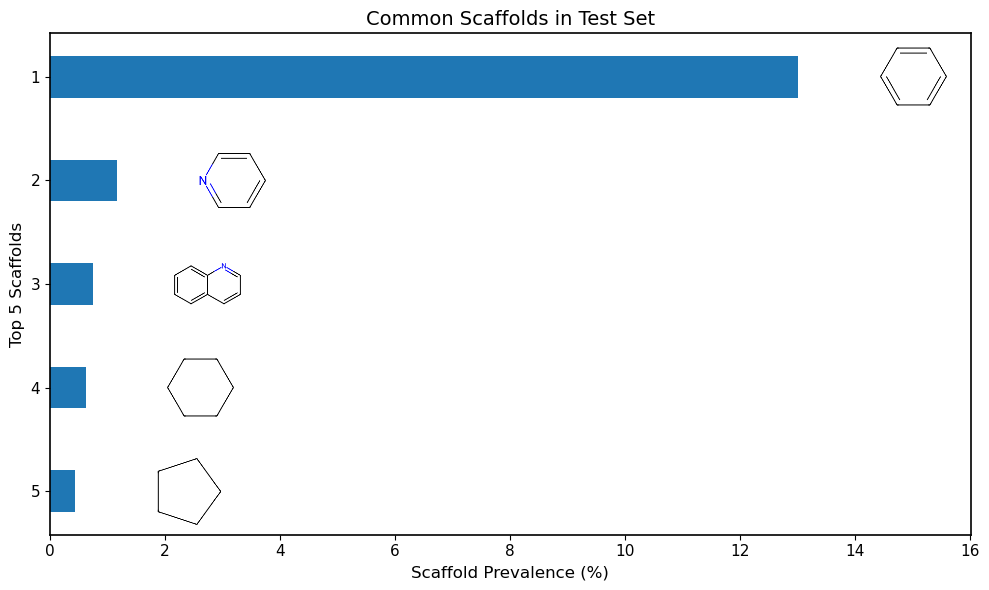

In [12]:
#example of constructing scaffold prevalence figure, by percentages of scaffold frequency
scaffold_counts = {
    '1': 13.01,
    '2': 1.17,
    '3': 0.74,
    '4': 0.62,
    '5': 0.43
}

# Example SMILES (replace with actual examples)
scaffold_smiles = {
    '1': 'c1ccccc1',
    '2': 'c1ccncc1',
    '3': 'c1ccc2ncccc2c1',
    '4': 'C1CCCCC1',
    '5':'C1CCCC1'
}

# Sort and extract
sorted_items = sorted(scaffold_counts.items(), key=lambda x: x[1], reverse=True)
labels, counts = zip(*sorted_items)

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')      # White full figure background
ax.set_facecolor('white')             # White plot area background

y = range(len(counts))

# Horizontal bar plot
bars = ax.barh(y, counts, tick_label=labels, height=0.4)
ax.set_title('Common Scaffolds in Test Set', fontsize=14)

# Adjust layout spacing
fig.subplots_adjust(left=0.08, right=0.98)

# Shrink x-axis range slightly but keep it wide enough to fit images
max_count = max(counts)
ax.set_xlim(0, max_count + 3)  # Adjust this based on your data and molecule sizes

# Add RDKit molecule images next to the bars
for i, label in enumerate(labels):
    mol = Chem.MolFromSmiles(scaffold_smiles[label])
    img = Draw.MolToImage(mol, size=(150, 150))
    imagebox = OffsetImage(img, zoom=0.35)
    ab = AnnotationBbox(imagebox, (counts[i] + 2, i), frameon=False)
    ax.add_artist(ab)

# Add black border around the axis (like subplot frame)
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(1.2)

# Optional: Adjust tick label font size
ax.tick_params(labelsize=11)

# Reverse the y-axis so the highest scaffold appears at the top
ax.invert_yaxis()

# Label the axes
ax.set_xlabel('Scaffold Prevalence (%)', fontsize=12)
ax.set_ylabel('Top 5 Scaffolds', fontsize=12)

# Save high-res white-background TIFF
plt.tight_layout()
#plt.savefig('Scaffold_prevalence_in_training_set.tiff', format='tiff', dpi=300)

plt.show()


In [13]:
models = {
    "XGBClassifier": XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
#             tree_method='gpu_hist',
        **best_params_dict["XGBClassifier"]["best_params"]
    ),
    "CatBoostClassifier": CatBoostClassifier(
#         class_weights=catboost_class_weights,
        verbose=0,
#             task_type="GPU",
        **best_params_dict["CatBoostClassifier"]["best_params"]
    ),
    "LGBMClassifier": LGBMClassifier(
#             device='gpu',
        **best_params_dict["LGBMClassifier"]["best_params"]
    ),
    "RandomForestClassifier": RandomForestClassifier(
        **best_params_dict["RandomForestClassifier"]["best_params"]
    ),
    "HistGradientBoostingClassifier": HistGradientBoostingClassifier(
        **best_params_dict["HistGradientBoostingClassifier"]["best_params"]
    )
}

In [14]:
def train_models_with_best_params_and_weights(X_train, y_train, class_weight_scheme, best_params_dict, seed=42):
    # y = [int(i/4) for i in y_train['phase']]
    y = list(y_train['phase'])
    sample_weights = compute_sample_weight(class_weight=class_weight_scheme, y=y)

    class_counts = Counter(y)
    total_samples = sum(class_counts.values())
    catboost_class_weights = {
        0: total_samples / class_counts[0],  # Weight for class 0
        1: total_samples / class_counts[1]   # Weight for class 1
    }
    catboost_class_weights = [total_samples / class_counts[i] for i in sorted(class_counts)]

    # Inject random_state / random_seed into best_params
    for model_name, model_info in best_params_dict.items():
        if model_name == "CatBoostClassifier":
            model_info["best_params"]["random_seed"] = seed
        else:
            model_info["best_params"]["random_state"] = seed

    models = {
        "XGBClassifier": XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            tree_method='gpu_hist',
            # base_score=0.5, 
            **best_params_dict["XGBClassifier"]["best_params"]
        ),
        "CatBoostClassifier": CatBoostClassifier(
            class_weights=catboost_class_weights,
            verbose=0,
            task_type="GPU",
            **best_params_dict["CatBoostClassifier"]["best_params"]
        ),
        "LGBMClassifier": LGBMClassifier(
            device='gpu',
            **best_params_dict["LGBMClassifier"]["best_params"]
        ),
        "RandomForestClassifier": RandomForestClassifier(
            **best_params_dict["RandomForestClassifier"]["best_params"]
        ),
        "HistGradientBoostingClassifier": HistGradientBoostingClassifier(
            **best_params_dict["HistGradientBoostingClassifier"]["best_params"]
        )
    }

    trained_models = {}
    for name in tqdm(models, desc="Training models"):
        model = models[name]
        if name == "CatBoostClassifier":
            trained_models[name] = model.fit(X_train, y)
        else:
            trained_models[name] = model.fit(X_train, y, sample_weight=sample_weights)

    return trained_models


In [15]:
#models_balanced = train_models_with_best_params_and_weights(X_train[descriptors],y_train,'balanced',best_params_dict)

In [16]:
# Load models into a new dictionary
models_balanced = {}

for name in models.keys():
    models_balanced[name] = joblib.load(f"saved_models_6618/{name}.pkl")
models_balanced

{'XGBClassifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.3325152889039984, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, feature_weights=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=0.021839352923182977,
               max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=1200, n_jobs=None,
               num_parallel_tree=None, ...),
 'CatBoostClassifier': <catboost.core.CatBoostClassifier at 0xc7698e12ab0>,
 'LGBMClassifier': LGBMClassifier(learning_rate=0.10763637487528757, max_depth=7,
     

In [17]:
def predict_ensemble(models_dict, new_test_set):
    prob_preds = [model.predict_proba(new_test_set)[:, 1] for model in models_dict.values()]
    final_pred_prob = np.mean(prob_preds, axis=0)
    return final_pred_prob

In [18]:
#data of test set molecules and clinical candidates
candidates_and_test = pd.read_csv(r'candidates_and_test_set.csv')
#calculating HADES score
candidates_and_test['HADES'] = predict_ensemble(models_balanced,candidates_and_test[descriptors])

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30


In [19]:
#calculation of accuracies  with  Bootstrap resampling

import numpy as np
from sklearn.utils import resample

def compute_accuracy(model, X_test, y_test):
    return accuracy_score(y_test, model.predict(X_test))

def bootstrap_confidence_interval(model, X_test, y_test, n_iterations=1000, ci=95):
    accuracies = []
    
    for _ in range(n_iterations):
        X_resampled, y_resampled = resample(X_test, y_test, n_samples=len(X_test))
        acc = compute_accuracy(model, X_resampled, y_resampled)
        accuracies.append(acc)
    
    mean_acc = np.mean(accuracies)
    lower_percentile = np.percentile(accuracies, (100 - ci) / 2)
    upper_percentile = np.percentile(accuracies, 100 - (100 - ci) / 2)
    
    return mean_acc, lower_percentile, upper_percentile

acc = []
for model_key, model in models_balanced.items():
    mean_acc, lower, upper = bootstrap_confidence_interval(model, X_test[descriptors], y_test['phase'])
    acc.append((model_key, mean_acc, lower, upper))

for model_key, mean_acc, lower, upper in acc:
    print(f"Model {model_key}: Accuracy = {mean_acc:.3f}, 95% CI = [{lower:.3f}, {upper:.3f}]")


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

In [20]:
# calculation of permutation importances and their StD values 

from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils._tags import ClassifierTags
import pandas as pd

# --- 1. Define your ensemble wrapper ---
class EnsembleMeanModel(BaseEstimator, ClassifierMixin):
    
    def __sklearn_tags__(self):
        tags = super().__sklearn_tags__()
        tags.estimator_type = "classifier"
        tags.classifier_tags = ClassifierTags()
        tags.target_tags.required = True
        return tags
    
    def __init__(self, models_dict):
        self.models_dict = models_dict
        self.classes_ = np.array([0, 1])
        self.__sklearn_tags__().estimator_type = "classifier"
        
    def predict(self, X):
        import numpy as np
        preds = [model.predict(X) for model in self.models_dict.values()]
        return np.mean(preds, axis=0).round().astype(int)  # for classification (adjust if regression)

    def predict_proba(self,X):
        import numpy as np
        preds = [model.predict_proba(X) for model in self.models_dict.values()]
        return np.mean(preds, axis=0)

    def fit(self, X, y):
        for model in self.models_dict.values():
            model.fit(X, y)
        return self

    def get_params(self, deep=False):
        # Required for compatibility with sklearn functions like permutation_importance
        return {'models_dict': self.models_dict}


# --- 2. Build the ensemble safely (without self-reference) ---
# Create a copy of models dict without any potential 'EnsembleMean'
base_models = {name: model for name, model in models_balanced.items() if name != 'EnsembleMean'}

# Add ensemble model
models_balanced['EnsembleMean'] = EnsembleMeanModel(models_dict=base_models)

# --- 3. Compute permutation importance for each model ---
perm_importances_mean = {}
perm_importances_std = {}

for name, model in models_balanced.items():
    if name !='EnsembleMean':
        continue
    print(f"Calculating permutation importance for: {name}")
    
    result = permutation_importance(
        model,
        X_test,
        list(y_test['phase']),
        n_repeats=10,
        random_state=42,
        n_jobs=1,  # Avoid parallel recursion issues; safe serial execution
        scoring='roc_auc'
    )
    
    perm_importances_mean[name] = pd.Series(result.importances_mean, index=X_test.columns)
    perm_importances_std[name] = pd.Series(result.importances_std, index=X_test.columns)

# --- 4. Optional: Convert to DataFrames for analysis ---
df_perm_means = pd.DataFrame(perm_importances_mean)
df_perm_stds = pd.DataFrame(perm_importances_std)

# Example: show top 10 features by importance for EnsembleMean
print(df_perm_means['EnsembleMean'].sort_values(ascending=False).head(10))


Calculating permutation importance for: EnsembleMean
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Curren

In [21]:
perm_importances_mean = {}
perm_importances_std = {}


for name, model in models_balanced.items():
    print(f"Calculating permutation importance for: {name}")

    result = permutation_importance(
        model,
        X_test,
        list(y_test['phase']),
        n_repeats=10,
        random_state=42,
        n_jobs=1,
        scoring='roc_auc'
    )

    perm_importances_mean[name] = pd.Series(
        result.importances_mean, index=X_test.columns
    )
    perm_importances_std[name] = pd.Series(
        result.importances_std, index=X_test.columns
    )


Calculating permutation importance for: XGBClassifier
Calculating permutation importance for: CatBoostClassifier
Calculating permutation importance for: LGBMClassifier
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value

In [22]:
dfs = []

for model_name, series in perm_importances_mean.items():
    top = series.sort_values(ascending=False).head(len(X_test.columns))

    df_model = pd.DataFrame({
        f"{model_name} - feature": top.index,
        f"{model_name} - importance value": top.values
    }).reset_index(drop=True)

    dfs.append(df_model)


In [23]:
df_importance_table = pd.concat(dfs, axis=1)
df_importance_table

,XGBClassifier - feature,XGBClassifier - importance value,CatBoostClassifier - feature,CatBoostClassifier - importance value,LGBMClassifier - feature,LGBMClassifier - importance value,RandomForestClassifier - feature,RandomForestClassifier - importance value,HistGradientBoostingClassifier - feature,HistGradientBoostingClassifier - importance value,EnsembleMean - feature,EnsembleMean - importance value
0,BCUTd-1l,0.019112,BCUTd-1l,0.020015,BCUTd-1l,0.031845,BCUTd-1l,0.011035,BCUTd-1l,0.023991,BCUTd-1l,0.013665
1,ZMIC2,0.005279,n6Ring,0.007195,VE1_A,0.012014,VE1_A,0.002946,ZMIC2,0.007517,VE1_A,0.004536
2,VE1_A,0.004759,ATS0Z,0.006272,ZMIC2,0.006593,ZMIC2,0.002240,VE1_A,0.006949,ZMIC2,0.003107
3,BBB_Martins,0.001838,VE1_A,0.006219,ATS0Z,0.003165,stereo_centers,0.001196,n6Ring,0.003694,n6Ring,0.001647
4,BCUTm-1l,0.001649,ZMIC2,0.005371,BBB_Martins,0.002565,JGI8,0.001195,BBB_Martins,0.002839,CYP2C19_Veith,0.001507
...,...,...,...,...,...,...,...,...,...,...,...,...
242,GATS3Z,-0.000438,AXp-2dv,-0.001062,AATS4m,-0.000637,GATS1dv,-0.000558,GATS2s,-0.000707,NR-ER-LBD,-0.000534
243,AMID_O,-0.000451,PEOE_VSA12,-0.001173,EState_VSA3,-0.000647,AATS4i,-0.000594,CYP2D6_Veith,-0.000823,ALERTS,-0.000566
244,ATSC2v,-0.000616,ATSC6dv,-0.001218,AATSC3m,-0.000651,BCUTd-1h,-0.000690,ATSC2v,-0.000875,AETA_eta_BR,-0.000592
245,NR-ER-LBD,-0.000650,ALERTS,-0.001364,AATSC4m,-0.000669,AATSC1s,-0.000758,ATSC6dv,-0.000889,ATSC6m,-0.000630


In [24]:
df_violinplots = pd.read_csv(r'6618 molecules test and pahses all scores.csv', index_col=0)
df_violinplots

,phase,XGBClassifier,CatBoostClassifier,LGBMClassifier,RandomForestClassifier,HistGradientBoostingClassifier,HADES,SMILES,QED,DBPP_SCORE,MolSkill
Unnamed: 0,,,,,,,,,,,
0,0,0.164919,0.026542,3.019184e-02,0.271035,0.008571,0.100252,COc1ccc(cc1N2CCNCC2)S(=O)(=O)N3CCCc4c(Cl)cc(Cl...,0.762801,0.003351,-7.591564
1,0,0.012352,0.000435,5.330000e-06,0.067113,0.000013,0.015984,CC1=C(C23OC2CNCC3C)C(=O)N(C)C1,0.642423,0.484632,-1.843633
2,0,0.003009,0.006068,5.650000e-07,0.087856,0.000005,0.019388,CC1Oc2cc(O)c(Br)nc2C12CCOC=N2,0.743972,0.002626,4.936094
3,4,0.942918,0.964935,9.999726e-01,0.802085,0.999745,0.941931,CC12CC(C3C(C1CCC2(C(=O)COP(=O)(O)O)O)CCC4=CC(=...,0.483999,0.999907,10.251916
4,0,0.013525,0.003059,2.090000e-07,0.043840,0.000151,0.012115,CC1OCC(O)(C2C=CC(N)CC2N)C1C,0.549831,0.016779,16.718570
...,...,...,...,...,...,...,...,...,...,...,...
3736,1,0.675135,0.942746,9.939816e-01,0.509580,0.948326,0.813954,CCOc1cc2ncc(C#N)c(Nc3ccc(OCc4cccc(F)c4)c(Cl)c3...,0.193117,0.943808,8.550327
3737,1,0.048691,0.028878,7.737140e-04,0.258523,0.003191,0.068012,N#CCCNc1nonc1-c1nc2ccccc2n1CC(=O)c1ccc(NC(=O)C...,0.151975,0.791588,5.377078
3738,1,0.112522,0.008127,1.048880e-04,0.225086,0.000577,0.069283,CC1CCC(n2c3cnccc3c3cnc(Nc4ccc5c(n4)CCN(C(=O)CO...,0.466542,0.015838,1.244759


In [25]:
def plot_violin_collage(df, model_names, acc_list=None):

    # ---- Filter MolSkill between 5th and 95th percentiles ----
    low = df['MolSkill'].quantile(0.05)
    high = df['MolSkill'].quantile(0.95)

    df_filtered = df[(df['MolSkill'] >= low) & (df['MolSkill'] <= high)]

    # ---------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    axes = axes.flatten()

    for i, model in enumerate(model_names):
        ax = axes[i]

        # Prepare the data: phase + one model column
        temp_df = df_filtered[['phase', model]].rename(
            columns={model: 'probability'}
        )

        sns.violinplot(
            x='phase',
            y='probability',
            data=temp_df,
            inner="quartile",
            palette="pastel",
            ax=ax
        )

        ax.set_title(f'Model: {model}', fontsize=12)
        ax.set_xlabel('Phase')
        ax.set_ylabel('Predicted Probability')
        ax.set_xticks([0, 1, 2, 3, 4])

    plt.tight_layout()
    plt.show()


/tmp/ipykernel_4159520/3375578981.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_4159520/3375578981.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_4159520/3375578981.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_4159520/3375578981.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


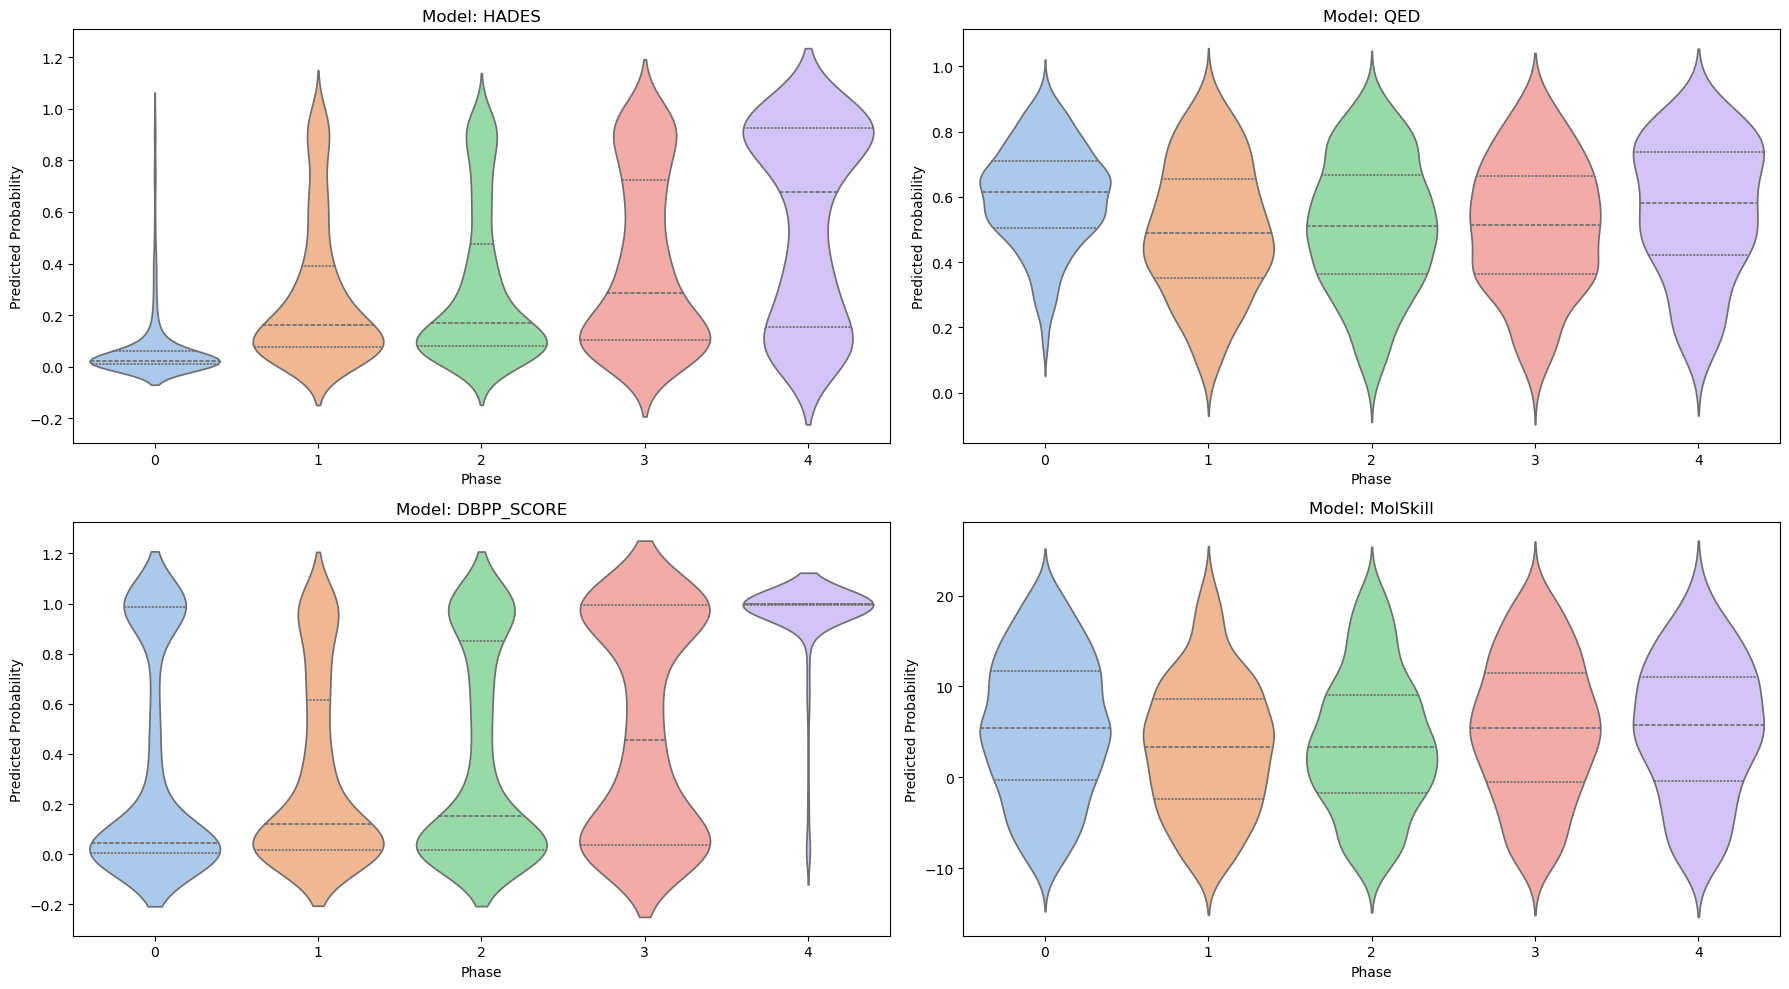

In [27]:
plot_violin_collage(df_violinplots,['HADES','QED','DBPP_SCORE','MolSkill'])

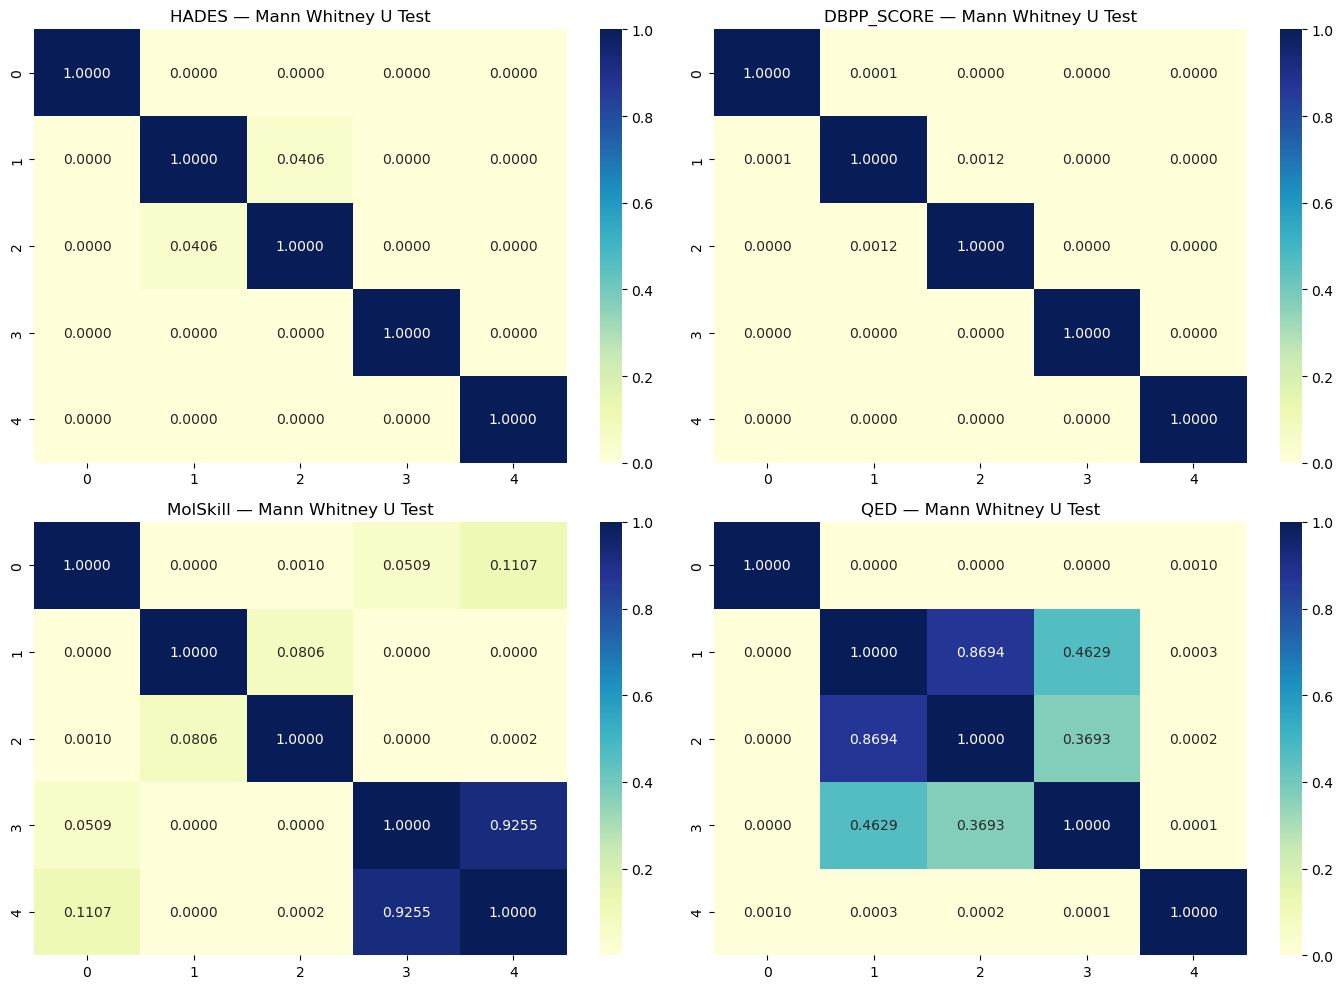

In [28]:
#Mann Whitney U test 
# Define the columns you want to analyze
columns_to_analyze = ['HADES','DBPP_SCORE', 'MolSkill', 'QED']


# Prepare figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten to make indexing easier

for idx, col in enumerate(columns_to_analyze):
    posthoc = sp.posthoc_mannwhitney(df_violinplots, val_col=col, group_col='phase')
    sns.heatmap(posthoc, annot=True, cmap="YlGnBu", fmt=".4f", ax=axes[idx])
    axes[idx].set_title(f"{col} — Mann Whitney U Test")
    
# Final layout
plt.tight_layout()
plt.show()

In [29]:
#pairwise roc-auc scores

In [30]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
import itertools

def predict_ensemble_proba(models, new_test_set):
    prob_preds = [model.predict_proba(new_test_set)[:, 1] for model in models]
    final_pred_prob = np.mean(prob_preds, axis=0)
    return final_pred_prob

def calculate_auc_mean_std_matrix(phases, y_probs, n_iterations=1000, random_state=42):
    phase_order = sorted(phases.unique())
    rng = np.random.default_rng(seed=random_state)

    df = pd.DataFrame({
        'phase': phases,
        'y_score': y_probs
    })
    df['phase'] = pd.Categorical(df['phase'], categories=phase_order, ordered=True)

    auc_combined_matrix = pd.DataFrame(index=phase_order, columns=phase_order, dtype=object)

    for p1, p2 in itertools.combinations(phase_order, 2):
        df_pair = df[df['phase'].isin([p1, p2])].copy()
        high, low = max(p1, p2), min(p1, p2)

        auc_scores = []

        for _ in range(n_iterations):
            high_group = df_pair[df_pair['phase'] == high]
            low_group = df_pair[df_pair['phase'] == low]

            if high_group.empty or low_group.empty:
                continue

            sample_high = high_group.sample(n=len(high_group), replace=True, random_state=rng)
            sample_low = low_group.sample(n=len(low_group), replace=True, random_state=rng)

            df_sample = pd.concat([sample_high, sample_low])
            df_sample['binary_label'] = df_sample['phase'].apply(lambda x: 1 if x == high else 0)

            if df_sample['binary_label'].nunique() < 2:
                continue

            auc = roc_auc_score(df_sample['binary_label'], df_sample['y_score'])
            auc_scores.append(auc)

        if auc_scores:
            mean_auc = np.mean(auc_scores)
            std_auc = np.std(auc_scores)
            formatted = f"{mean_auc:.2f}±{std_auc:.2f}"
            auc_combined_matrix.at[low, high] = formatted
            auc_combined_matrix.at[high, low] = formatted

    # Fill diagonals
    for p in phase_order:
        auc_combined_matrix.at[p, p] = "1.00±0.00"

    return auc_combined_matrix


In [31]:
#one example below is for HADES, calculate also for other scores
calculate_auc_mean_std_matrix(df_violinplots['phase'], df_violinplots['HADES'])

,0,1,2,3,4
0,1.00±0.00,0.86±0.01,0.87±0.01,0.90±0.01,0.92±0.01
1,0.86±0.01,1.00±0.00,0.53±0.01,0.62±0.02,0.71±0.02
2,0.87±0.01,0.53±0.01,1.00±0.00,0.59±0.02,0.68±0.02
3,0.90±0.01,0.62±0.02,0.59±0.02,1.00±0.00,0.60±0.02
4,0.92±0.01,0.71±0.02,0.68±0.02,0.60±0.02,1.00±0.00


In [32]:
#performance across compound set

In [34]:
new_2024_after_drugs=pd.read_csv(r'2024 after drugs smi 4 scores.csv')
odds_final=pd.read_csv(r'odd molecules smi 4 scores.csv')
small_rings=pd.read_csv(r'small rings smi 4 scores.csv')
toxicity_panel = pd.read_csv(r'oral toxics smi 4 scores.scv')

In [35]:
final_list_4 = df_violinplots[df_violinplots['phase'] ==4 ]

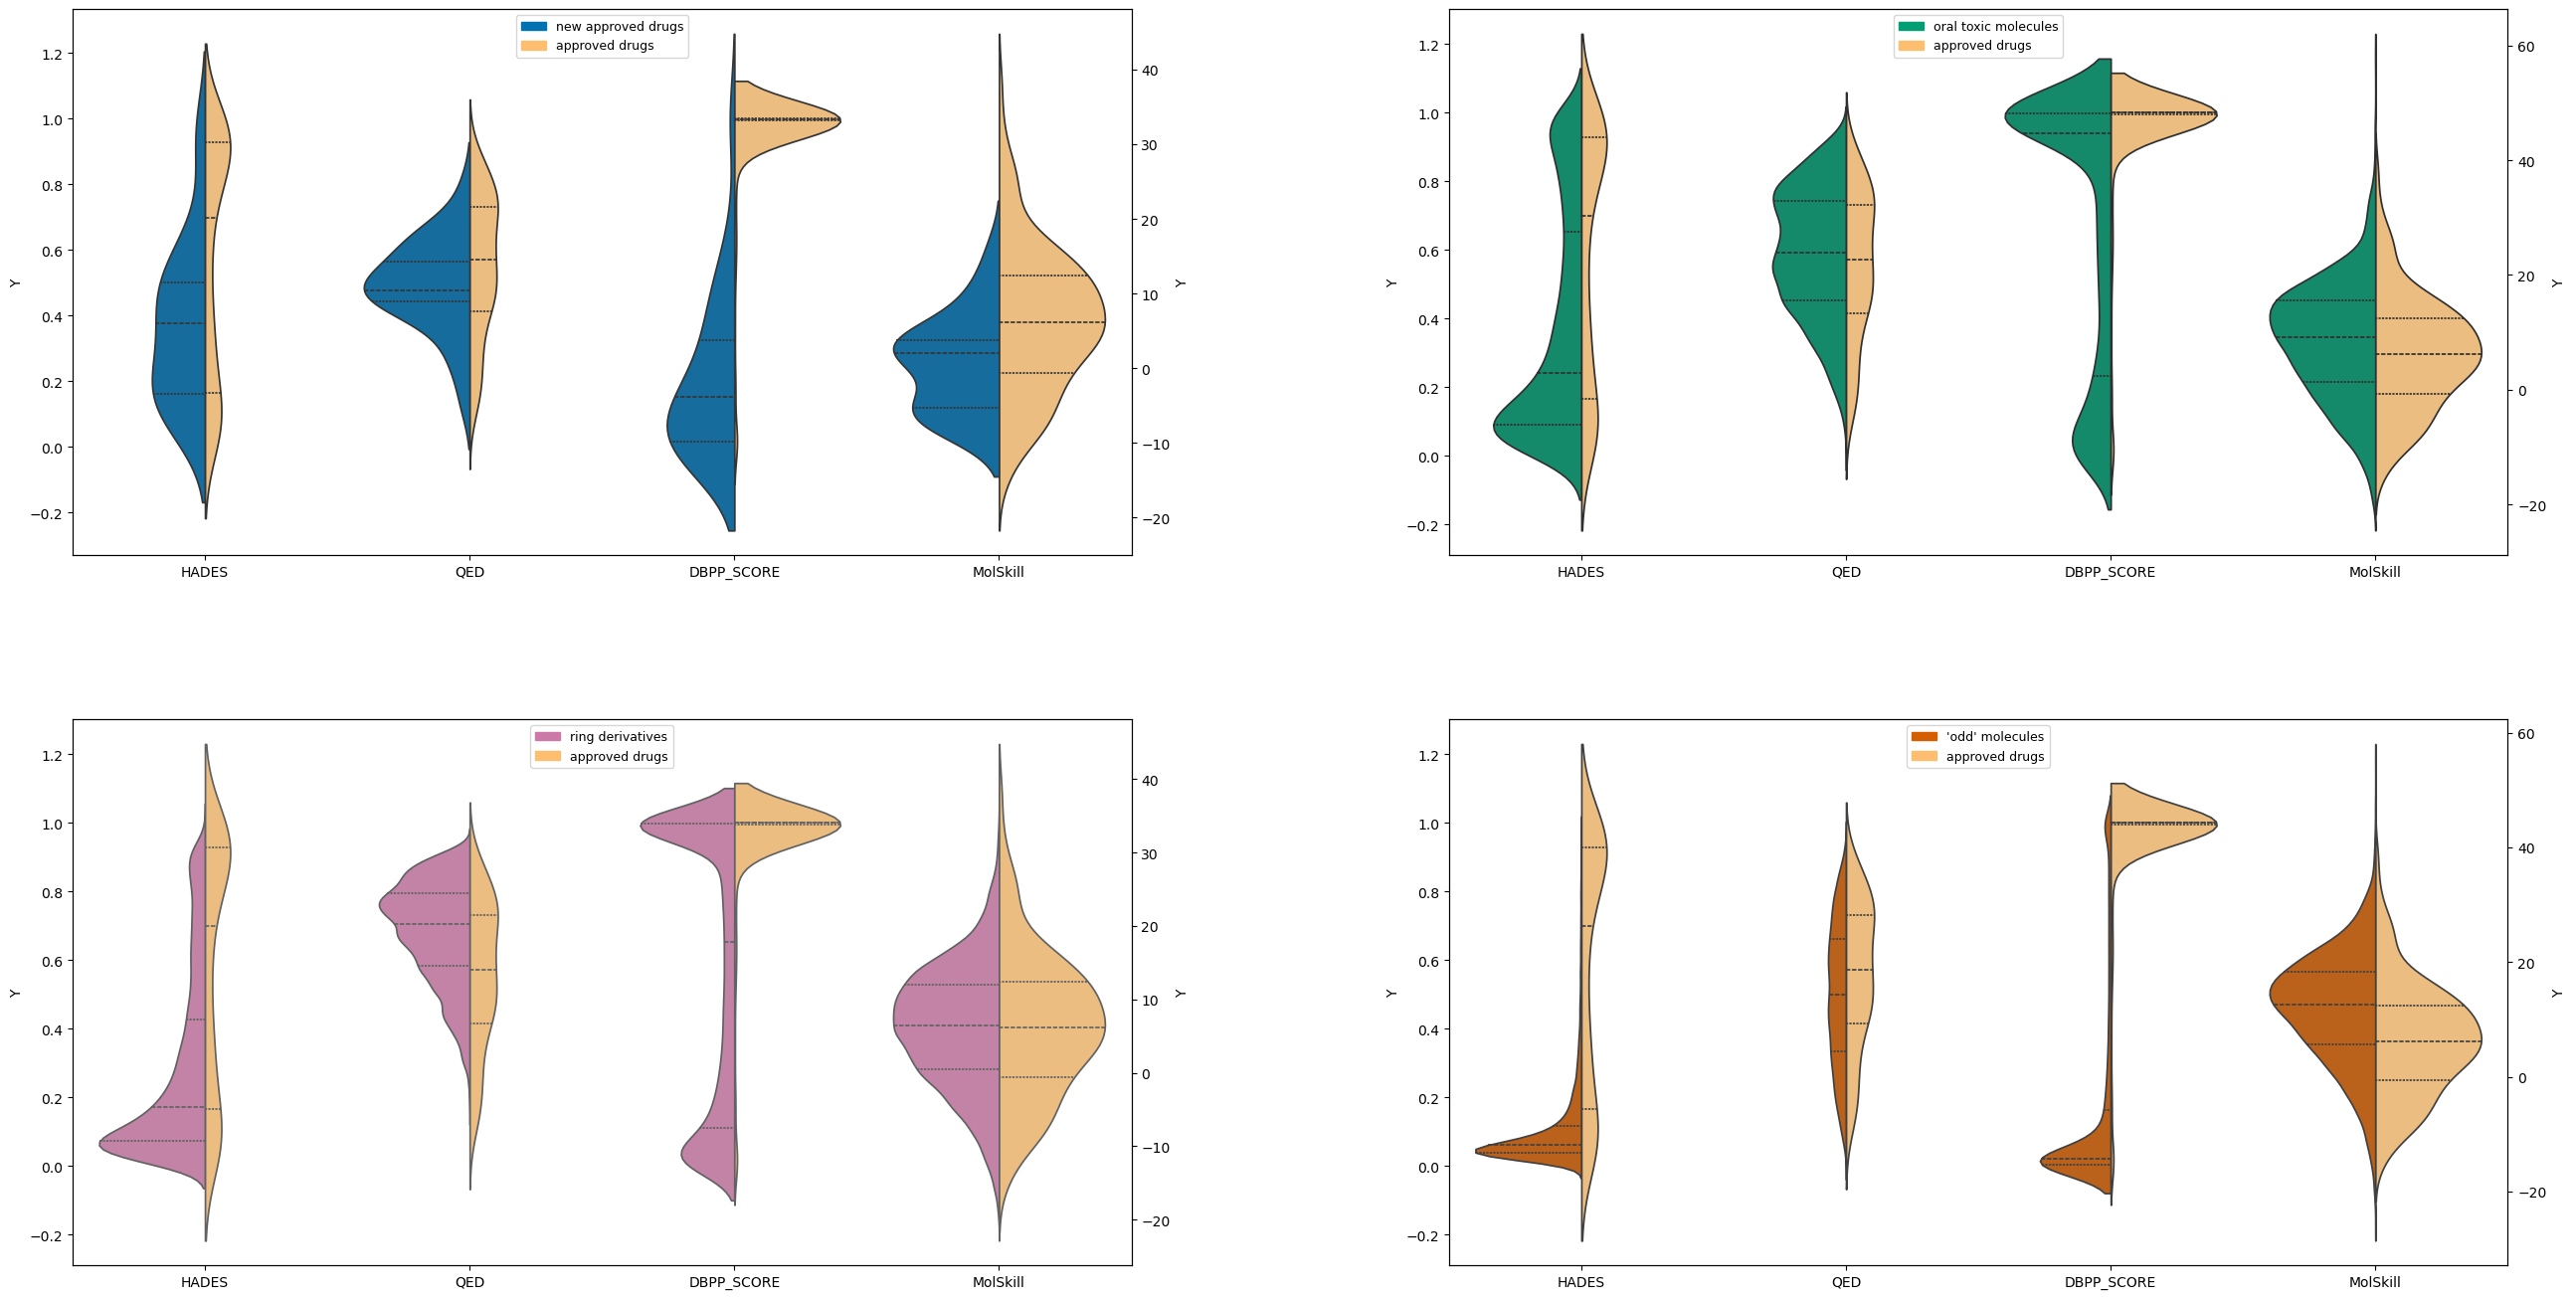

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

# Define the low and high range scores
low_range_scores = ['HADES', 'QED', 'DBPP_SCORE']
high_range_scores = ['MolSkill']

# Custom labels for the Odds datasets (in order of dataset_pairs)
labels = [
    "new approved drugs",
    "oral toxic molecules",
    "ring derivatives",
    "'odd' molecules"
]

def make_violin_with_twin(ax, df_compounds, df_drugs, compounds_color, compounds_label):
    # Melt datasets for low range
    df1_melted_low = df_compounds[low_range_scores].melt(var_name='Variable', value_name='Y')
    df1_melted_low['Dataset'] = 'Cmpd'
    df2_melted_low = df_drugs[low_range_scores].melt(var_name='Variable', value_name='Y')
    df2_melted_low['Dataset'] = 'final_list_4'
    combined_low = pd.concat([df1_melted_low, df2_melted_low]).reset_index(drop=True)
    
    # Melt datasets for MolSkill (high range)
    df1_melted_high = df_compounds[high_range_scores].melt(var_name='Variable', value_name='Y')
    df1_melted_high['Dataset'] = 'Cmpd'
    df2_melted_high = df_drugs[high_range_scores].melt(var_name='Variable', value_name='Y')
    df2_melted_high['Dataset'] = 'final_list_4'
    combined_high = pd.concat([df1_melted_high, df2_melted_high]).reset_index(drop=True)
    
    # Colors
    palette = {'Cmpd': compounds_color, 'final_list_4': '#FDBF6F'}  # Peach

    # Plot low range on main axis
    sns.violinplot(
        x='Variable', y='Y', hue='Dataset',
        data=combined_low, split=True, inner='quart',
        palette=palette, ax=ax
    )
    ax.set_xlabel('')
    ax.legend().remove()
    
    # Plot MolSkill on twin axis
    ax2 = ax.twinx()
    sns.violinplot(
        x='Variable', y='Y', hue='Dataset',
        data=combined_high, split=True, inner='quart',
        palette=palette, ax=ax2
    )
    ax2.legend().remove()
    
    # Custom legend on the main axis
    compounds_patch = mpatches.Patch(color=compounds_color, label=compounds_label)
    final_list_patch = mpatches.Patch(color='#FDBF6F', label='approved drugs')  # Light Yellow in legend
    ax.legend(handles=[compounds_patch, final_list_patch], loc='upper center', bbox_to_anchor=(0.5, 1), fontsize=9)

# Example dataset pairs (Replace with actual dataframes)
dataset_pairs = [
    (new_2024_after_drugs, final_list_4),
    (toxicity_panel, final_list_4),
    (small_rings, final_list_4),
    (odds_final, final_list_4)
]

# Colorblind-safe colors
compounds_colors = ['#0072B2', '#009E73', '#CC79A7', '#D55E00']

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(26, 14))

# Loop through axes and dataset pairs
for ax, ((df_compounds, df_drugs), compounds_color, compounds_label) in zip(
        axes.flatten(), zip(dataset_pairs, compounds_colors, labels)):
    make_violin_with_twin(ax, df_compounds, df_drugs, compounds_color, compounds_label)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.93, wspace=0.3, hspace=0.3)

# Save the plot (optional)
# plt.savefig("Stress_tests_violinplots.tiff", dpi=300, format='tiff')

# Show the plot
plt.show()


In [37]:
from scipy.stats import mannwhitneyu

# Store results
mannwhitney_results = []
iqr_results = []

# Go through each dataset pair
for (df_compounds, df_drugs), label in zip(dataset_pairs, labels):
    for score in low_range_scores + high_range_scores:
        # Drop NaNs for clean statistical testing
        compounds_values = df_compounds[score].dropna()
        drugs_values = df_drugs[score].dropna()
        
        # Mann-Whitney U Test (non-parametric test for independent samples)
        stat, p_value = mannwhitneyu(compounds_values, drugs_values, alternative='two-sided')

        mannwhitney_results.append({
            'Comparison': label,
            'Score': score,
            'U_statistic': stat,
            'p_value': p_value,
            'Odds_median': compounds_values.median(),
            'Drugs_median': drugs_values.median()
        })

        # Calculate IQRs
        for name, values in [('CMPD', compounds_values), ('Drugs', drugs_values)]:
            q1 = values.quantile(0.25)
            q3 = values.quantile(0.75)
            iqr = q3 - q1
            iqr_results.append({
                'Dataset': name,
                'Comparison': label,
                'Score': score,
                'Q1': q1,
                'Q3': q3,
                'IQR': iqr
            })

# Convert to DataFrames for easier viewing or exporting
mannwhitney_df = pd.DataFrame(mannwhitney_results)
iqr_df = pd.DataFrame(iqr_results)

# Display or export
print("\n=== Mann-Whitney U Test Results ===\n")
print(mannwhitney_df)

print("\n=== IQR (Interquartile Range) Results ===\n")
print(iqr_df)

# Optionally save to CSV
# mannwhitney_df.to_csv("mannwhitney_results.csv", index=False)
# iqr_df.to_csv("iqr_results.csv", index=False)



=== Mann-Whitney U Test Results ===

              Comparison       Score  U_statistic        p_value  Odds_median  \
0     new approved drugs       HADES       2818.0   2.215369e-02     0.376801   
1     new approved drugs         QED       3069.0   8.002026e-02     0.477143   
2     new approved drugs  DBPP_SCORE        296.0   1.530552e-14     0.151111   
3     new approved drugs    MolSkill       2429.0   1.807247e-03     2.030089   
4   oral toxic molecules       HADES     350355.0   6.331261e-19     0.240849   
5   oral toxic molecules         QED     543234.0   2.247978e-02     0.591556   
6   oral toxic molecules  DBPP_SCORE     215050.5   9.277098e-63     0.938614   
7   oral toxic molecules    MolSkill     573390.5   5.617797e-05     9.197017   
8       ring derivatives       HADES    2966570.0   2.801591e-44     0.171285   
9       ring derivatives         QED    7419543.0   6.761629e-27     0.705432   
10      ring derivatives  DBPP_SCORE    1767488.0   2.309543e-94     0.

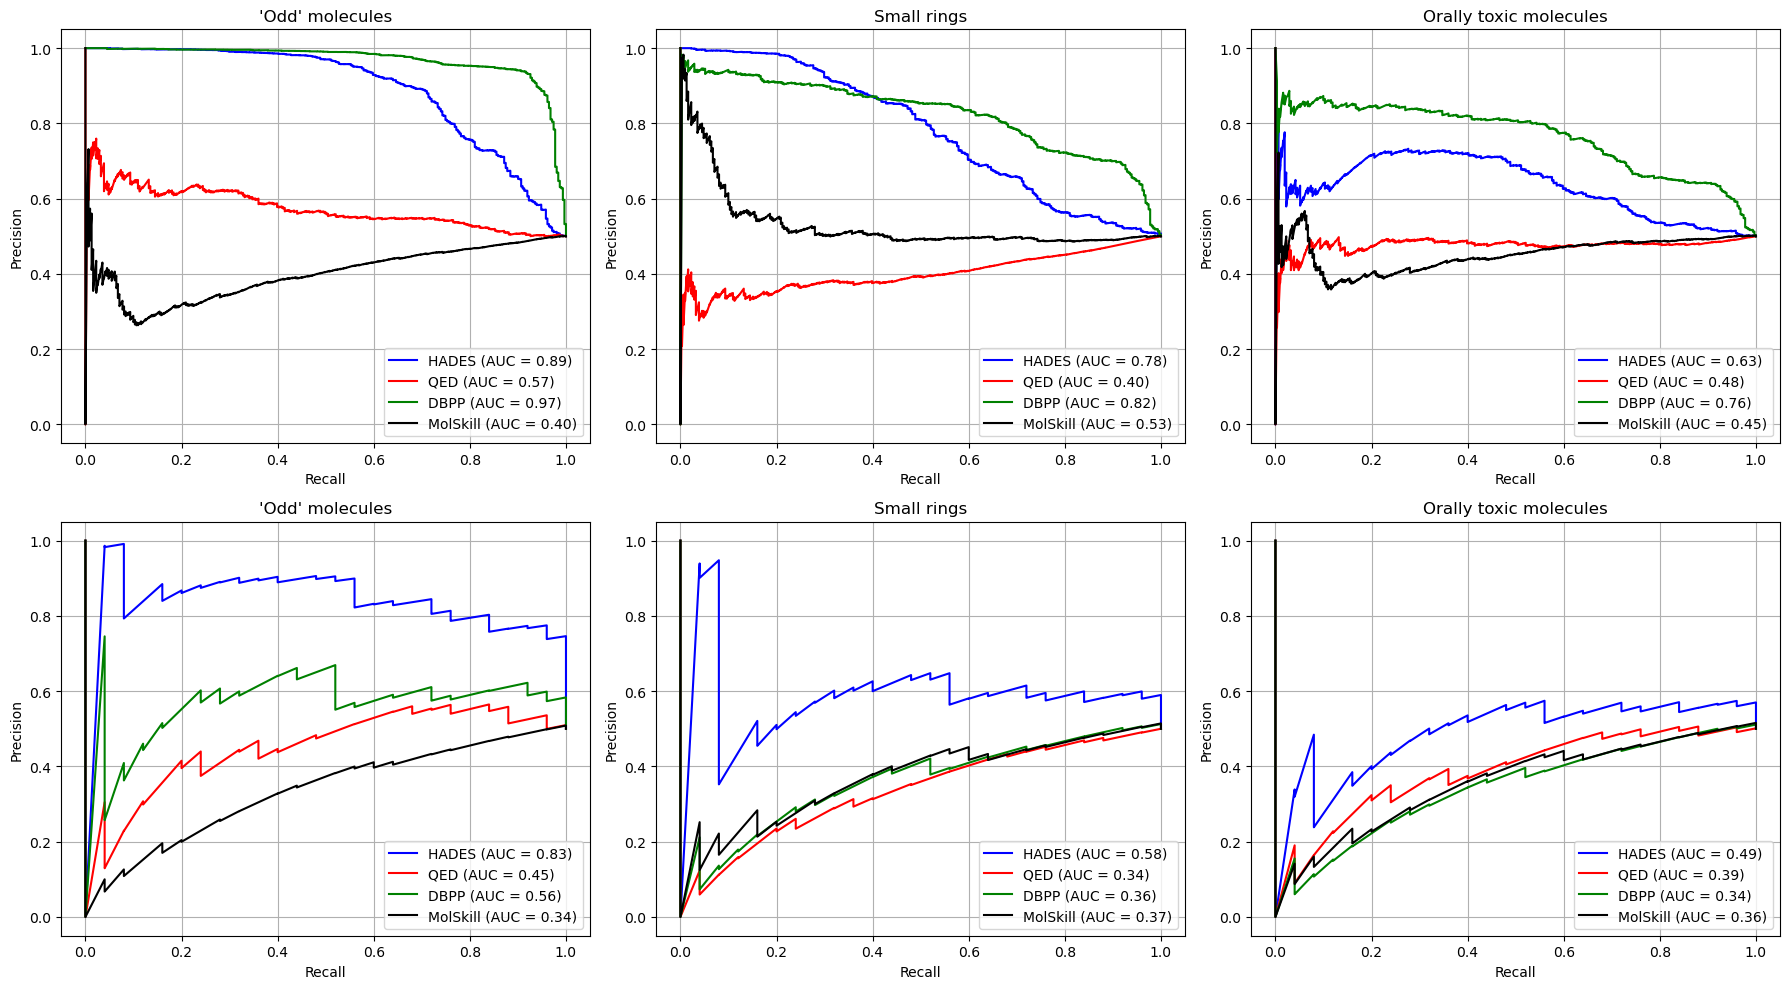

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

models = ['HADES', 'QED', 'DBPP_SCORE', 'MolSkill']
colors = {
    'HADES': 'blue',
    'QED': 'red',
    'DBPP_SCORE': 'green',
    'MolSkill': 'black'
}

d1_list = [odds_final, small_rings, toxicity_panel]
d2_top = final_list_4
d2_bottom = new_2024_after_drugs
titles = ["'Odd' molecules", 'Small rings', 'Orally toxic molecules']


def compute_pr_auc(d1, d2, model):
    y_true = [0] * len(d1) + [1] * len(d2)
    y_scores = d1[model].tolist() + d2[model].tolist()
    weights = [1 / len(d1)] * len(d1) + [1 / len(d2)] * len(d2)

    precision, recall, _ = precision_recall_curve(
        y_true, y_scores, sample_weight=weights
    )
    return precision, recall, auc(recall, precision)


fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for col, d1 in enumerate(d1_list):
    for row, d2 in enumerate([d2_top, d2_bottom]):
        ax = axs[row, col]

        for model in models:
            precision, recall, pr_auc = compute_pr_auc(d1, d2, model)
            ax.plot(
                recall,
                precision,
                label=f'{model.replace("_SCORE", "")} (AUC = {pr_auc:.2f})',
                color=colors[model]
            )

        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(titles[col])
        ax.legend(loc='lower right')
        ax.grid(True)

plt.tight_layout()
plt.show()


In [39]:
#performance in hit/lead optimizations

In [41]:
opt_molskill = pd.read_csv(r'optimizations_all_smiles_for_Molskill_results.csv', index_col = 0)
opt_molskill['MolSkill']  = opt_molskill['Molskill']
opt_molskill['cur_smi'] = opt_molskill['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [42]:
opt_dbpp = pd.read_csv(r'optimizations_all_smiles for dbpp calc.csv', index_col= 0)
opt_dbpp['cur_smi'] = opt_dbpp['SMILES'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))

In [43]:
import pandas as pd
import glob
from rdkit import Chem

# Load all matching CSV files
#csv_files = glob.glob(r'.\optimization cases\opt*_descriptors.csv')
csv_files = glob.glob(r'./optimization cases/opt*_descriptors.csv')

dict_df = {}

for i, filepath in enumerate(csv_files):
    try:
        # Read the CSV
        df = pd.read_csv(filepath)

        # Predict ensemble and model probabilities
        df['Ensemble'] = predict_ensemble(models_balanced, df[descriptors])
#         df['W_ensemble'] = weighted_ensemble(models_balanced_5k, best_weights5,df[descriptors_5k])
        for mod in models_balanced.keys():
            df[mod] = models_balanced[mod].predict_proba(df[descriptors])[:, 1]  # Use [:, 1] instead of list comp

        # Try known SMILES column variants to standardize to canonical SMILES
        for smi_col in ['Smiles', 'Unnamed: 1', 'SMILES ', 'Smile ', 'smiles',
                        'Isomeric SMILES', 'SMILE', 'ï»¿canonical-smiles', 'Structure',
                        'SMILES', 'Smiles ', 'Molecular formula stings (CSV)', 'Smile']:

            if smi_col in df.columns:
                df['cur_smi'] = df[smi_col].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)) if pd.notnull(x) else None)

                # Merge with DBPP data
                # Merge with DBPP data
                merged = df.merge(opt_dbpp[['cur_smi', 'DBPP_SCORE']], on='cur_smi', how='left')
                merged = merged.rename(columns={'DBPP_SCORE': 'DBPP'})

                # Merge with MolSkill data
                merged = merged.merge(opt_molskill[['cur_smi', 'MolSkill']], on='cur_smi', how='left')

                dict_df[i] = merged
                break  # Exit the loop once a valid SMILES column is found

        else:
            print(f"No SMILES column found in file {filepath}")

    except Exception as e:
        print(f"Error processing file {filepath}: {e}")


[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

In [44]:
df_ranges = pd.read_csv(r'ranges for each case.csv')
df_ranges = df_ranges.dropna()
df_ranges['name'] = df_ranges['name'].apply(lambda x: x.replace('di_','') + '_descriptors')

import ast
# lst = ast.literal_eval(string)
df_ranges['range']= df_ranges['range'].apply(lambda x: ast.literal_eval(x))
df_ranges

,name,range
0,opt1_descriptors,"[1, 22]"
1,opt2_descriptors,"[0, 50]"
2,opt3_descriptors,"[0, 26]"
3,opt4_descriptors,"[0, 70]"
4,opt5_descriptors,"[6, 15]"
...,...,...
95,opt96_descriptors,"[40, 76]"
96,opt97_descriptors,"[14, 23]"
97,opt98_descriptors,"[0, 62]"
98,opt99_descriptors,"[0, 6]"


In [45]:
start_dict = {'SMILES':[],'DBPP':[],'HADES':[],'QED':[],'MolSkill':[]}
end_dict = {'SMILES':[],'DBPP':[],'HADES':[],'QED':[],'MolSkill':[]}
name_lis = []
for j, i in enumerate(csv_files):
    name = (i.split('/')[-1]).replace('.csv', '')
    
    # Check if the name is in the first 100 names of df_ranges
    if name in list(df_ranges['name'][:100]):
        name_lis.append(name)
        start = list(df_ranges[df_ranges['name'] == name]['range'])[0][0]
        end = list(df_ranges[df_ranges['name'] == name]['range'])[0][1]
        data = dict_df[j]
        for i in ['Smiles', 'Unnamed: 1', 'SMILES ', 'Smile ', 'smiles',
                        'Isomeric SMILES', 'SMILE', 'ï»¿canonical-smiles', 'Structure',
                        'SMILES', 'Smiles ', 'Molecular formula stings (CSV)', 'Smile']:
            try:
                start_dict['SMILES'].append(data.loc[start][i])
                start_dict['HADES'].append(data.loc[start]['HADES'])
                start_dict['QED'].append(data.loc[start]['QED'])
                start_dict['DBPP'].append(data.loc[start]['DBPP'])
                start_dict['MolSkill'].append(data.loc[start]['MolSkill'])
        
                
                end_dict['SMILES'].append(data.loc[end-1][i])
                end_dict['HADES'].append(data.loc[end-1]['HADES'])
                end_dict['QED'].append(data.loc[end-1]['QED'])
                end_dict['DBPP'].append(data.loc[end-1]['DBPP'])
                end_dict['MolSkill'].append(data.loc[end-1]['MolSkill'])
            except:
                continue

In [46]:
SAR_paper = pd.concat([pd.DataFrame(name_lis, columns = ['name']),pd.DataFrame(start_dict), pd.DataFrame(end_dict)], axis = 1)#.to_csv(r'optimization_cases_for_paper.csv', index = False)

In [58]:
# import matplotlib.pyplot as plt
# import pandas as pd

# def plot_selected_range(data, start_idx, end_idx):
#     """
#     Plots selected range from a given dataset.

#     :param data: DataFrame containing the data.
#     :param start_idx: Start index for slicing.
#     :param end_idx: End index for slicing.
#     """

#     # Create a new figure for each plot
#     plt.figure(figsize=(10, 6))

#     # Plot the original lines with specified colors (only from start_idx to end_idx)
#     plt.plot(data['QED'][start_idx:end_idx], label='QED', color='blue')
#     plt.plot(data['HADES'][start_idx:end_idx], label='HADES', color='coral')
#     plt.plot(data['Ensemble'][start_idx:end_idx], label='Ensemble', color='red')
#     plt.plot(data['DBPP'][start_idx:end_idx], label='DBPP', color='black')
#     plt.plot(data['MolSkill'][start_idx:end_idx], label='MolSkill', color='green')

#     # Add dashed lines between the first and last points in the selected range
#     plt.plot([start_idx, end_idx - 1],  
#              [data['QED'].iloc[start_idx], data['QED'].iloc[end_idx - 1]], linestyle='--', color='blue')

#     plt.plot([start_idx, end_idx - 1],  
#              [data['HADES'].iloc[start_idx], data['HADES'].iloc[end_idx - 1]], linestyle='--', color='coral')
#     plt.plot([start_idx, end_idx - 1],  
#              [data['Ensemble'].iloc[start_idx], data['Ensemble'].iloc[end_idx - 1]], linestyle='--', color='red')
#     plt.plot([start_idx, end_idx - 1],  
#              [data['DBPP'].iloc[start_idx], data['DBPP'].iloc[end_idx - 1]], linestyle='--', color='black')
#     plt.plot([start_idx, end_idx - 1],  
#              [data['MolSkill'].iloc[start_idx], data['MolSkill'].iloc[end_idx - 1]], linestyle='--', color='green')

#     # plt.plot([start_idx, end_idx - 1],  
#     #          [data['our_score_ctb'].iloc[start_idx], data['our_score_ctb'].iloc[end_idx - 1]], linestyle='--', color='green')

#     # Add legend
#     plt.legend()

#     # Show the plot
#     plt.show()
    
list_qed = []
list_dbpp = []
list_ensemble =[]
list_mskill = []

# Loop over each CSV and plot
for j, i in enumerate(csv_files):
    name = (i.split('/')[-1]).replace('.csv', '')
    
    # Check if the name is in the first 100 names of df_ranges
    if name in list(df_ranges['name'][:100]):
        print(name)
        start = list(df_ranges[df_ranges['name'] == name]['range'])[0][0]
        end = list(df_ranges[df_ranges['name'] == name]['range'])[0][1]
        
        # Read the data from the CSV
        data = dict_df[j]
        print(j)
        list_dbpp.append((data['DBPP'][end-1] - data['DBPP'][start]))
        list_qed.append((data['QED'][end-1] - data['QED'][start]))
        list_ensemble.append((data['Ensemble'][end-1]- data['Ensemble'][start]))
        list_mskill.append((data['MolSkill'][end-1] - data['MolSkill'][start]))


In [57]:
import pandas as pd

# -------------------------------
# INPUT DATA (example structure)
# -------------------------------
data = {
    'QED': list_qed,
    'DBPP': list_dbpp,
    'HADES': list_ensemble,
    'MolSkill':list_mskill
}

# -------------------------------
# THRESHOLDS
# -------------------------------
positive_thresholds = [0.001, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
negative_thresholds = [-0.001, -0.01, -0.02, -0.05, -0.1, -0.2, -0.3, -0.4, -0.5]

# -------------------------------
# CONVERT TO NUMERIC SERIES
# (strings → NaN safely)
# -------------------------------
data_series = {
    model: pd.to_numeric(pd.Series(values), errors='coerce')
    for model, values in data.items()
}

# -------------------------------
# RESULT TABLES
# -------------------------------
above_df = pd.DataFrame(index=positive_thresholds, columns=data_series.keys())
below_df = pd.DataFrame(index=negative_thresholds, columns=data_series.keys())

# -------------------------------
# CALCULATIONS
# -------------------------------
for model, values in data_series.items():
    total = values.count()  # excludes NaNs automatically

    above_df[model] = [
        round((values > t).sum() / total * 100, 0)
        if total > 0 else 0
        for t in positive_thresholds
    ]

    below_df[model] = [
        round((values < t).sum() / total * 100, 0)
        if total > 0 else 0
        for t in negative_thresholds
    ]

# -------------------------------
# LABELS
# -------------------------------
above_df.index.name = "Threshold (>)"
below_df.index.name = "Threshold (<)"
above_df.columns.name = below_df.columns.name = "Model"

# -------------------------------
# OUTPUT
# -------------------------------
print("🔼 Percentage ABOVE thresholds")
print(above_df)

print("\n🔽 Percentage BELOW thresholds")
below_df


🔼 Percentage ABOVE thresholds
Model          QED  DBPP  HADES  MolSkill
Threshold (>)                            
0.001            0     0      0         0
0.010            0     0      0         0
0.020            0     0      0         0
0.050            0     0      0         0
0.100            0     0      0         0
0.200            0     0      0         0
0.300            0     0      0         0
0.400            0     0      0         0
0.500            0     0      0         0

🔽 Percentage BELOW thresholds


Model,QED,DBPP,HADES,MolSkill
Threshold (<),,,,
-0.001,0,0,0,0
-0.010,0,0,0,0
-0.020,0,0,0,0
-0.050,0,0,0,0
-0.100,0,0,0,0
-0.200,0,0,0,0
-0.300,0,0,0,0
-0.400,0,0,0,0
-0.500,0,0,0,0


In [ ]:
# Performance in virtual screening process

In [50]:
import os
import pandas as pd

folder_path = './screening libraries all scores'
# Get all CSV file names in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

libraries_dict = {}
for i in csv_files:
    name = i.split('.')[0].split('_')[0]
    libraries_dict[name] = pd.read_csv(os.path.join(folder_path, i))

#


In [51]:
for i in libraries_dict.keys():
    libraries_dict[i]['HADES'] = predict_ensemble(models_balanced, libraries_dict[i][descriptors])

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

In [52]:
def ef(data, score, percent, items='labels'):
    if percent <= 0:
        return 0  
    data2 = data.copy()    
    ascending = True if score == 'MolSkill' else False
    data2 = data2.sort_values(by=score, ascending=ascending).reset_index(drop=True)
    top_n = int(len(data2) * percent / 100)
    if top_n == 0:
        return 0  
    data2_top = data2.iloc[:top_n]
    active_ratio_top = len(data2_top[data2_top[items] == 1]) / len(data2_top)
    active_ratio_all = len(data2[data2[items] == 1]) / len(data2)
    if active_ratio_all == 0:
        return 0  
    enrichment_factor = active_ratio_top / active_ratio_all
    return enrichment_factor

In [53]:
import pandas as pd

# Your dictionary of DataFrames (where keys are names and values are the DataFrames)
dfs = libraries_dict

# Percentages and scores to evaluate
percentages = [1, 3, 5, 10]
scores = ['HADES', 'DBPP_SCORE', 'QED', 'MolSkill']

# Storage for results
all_results = []

# Loop through each dataset in the dictionary
for name, df in dfs.items():
    if name == 'SGLT':
        continue
    else:
        ef_results = {}
        for percent in percentages:
            ef_results[percent] = []
            for score in scores:
                ef_val = ef(df, score=score, percent=percent, items='labels')
                ef_results[percent].append(ef_val)
        
        # Create temporary DataFrame and add a 'Set' column
        ef_df = pd.DataFrame(ef_results, index=scores).T
        ef_df.index.name = 'Percent'
        ef_df.columns.name = 'Score'
        ef_df = ef_df.reset_index()
        ef_df['Set'] = name  # Add the name of the DataFrame as a column
        
        all_results.append(ef_df)

# Concatenate all results into one DataFrame
final_df = pd.concat(all_results, ignore_index=True)

# Rearrange columns for better readability
final_df = final_df[['Set', 'Percent'] + scores]

# Display the final DataFrame
(final_df)


Score,Set,Percent,HADES,DBPP_SCORE,QED,MolSkill
0,pi3k,1,21.472198,0.000000,0.000000,0.000000
1,pi3k,3,11.905236,0.000000,0.000000,0.000000
2,pi3k,5,7.148838,2.859535,0.000000,1.429768
3,pi3k,10,4.286739,3.572282,1.428913,0.714456
4,GABA-A,1,25.105634,25.105634,0.000000,0.000000
5,GABA-A,3,12.552817,12.552817,0.000000,0.000000
6,GABA-A,5,10.014045,7.510534,0.000000,0.000000
7,GABA-A,10,5.000000,5.000000,1.250000,0.000000
8,ANDROGENS,1,87.988479,87.988479,0.000000,0.000000
9,ANDROGENS,3,31.254001,30.176276,0.000000,2.155448


In [54]:
df_pi3k = libraries_dict['pi3k']


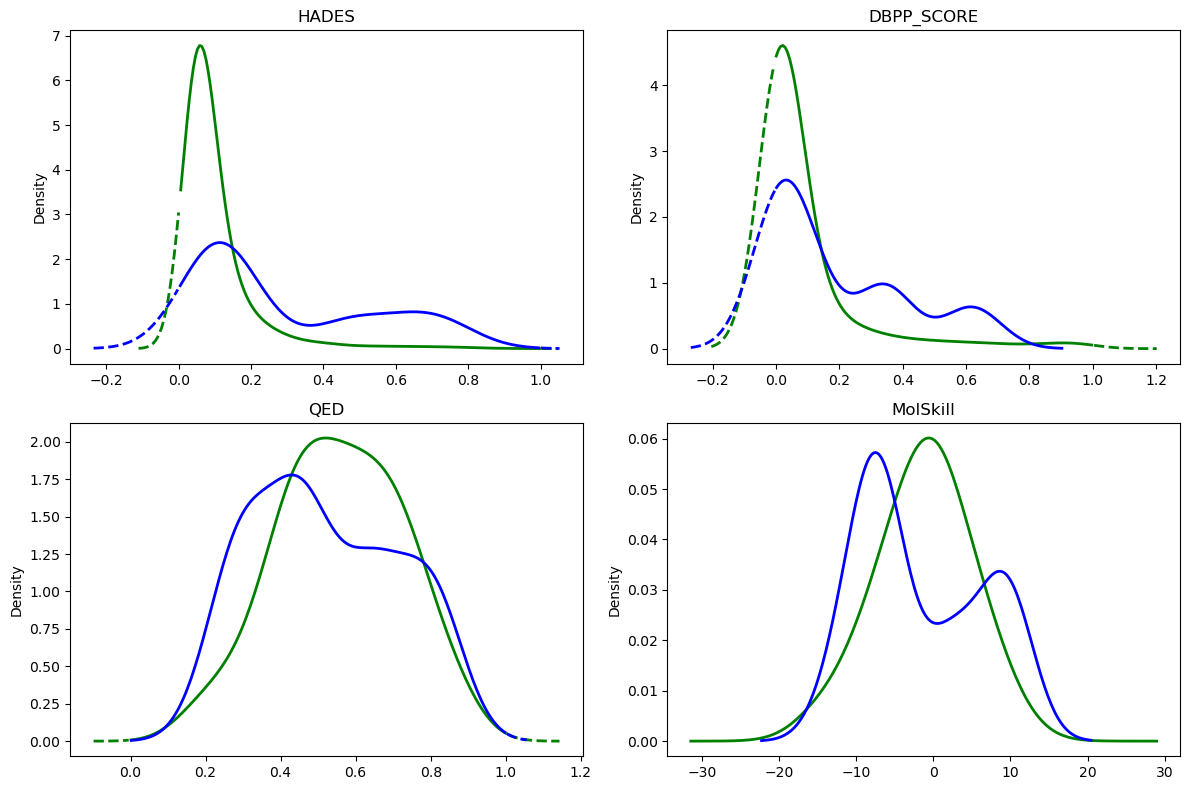

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_custom_kde(ax, data, label_name, bw_method=0.4):
    """
    Plot KDE with custom line styles:
    - label=0 (green), label=1 (blue)
    - MolSkill: always solid
    - Other scores: solid inside [0,1], dotted outside
    """
    colors = {0: "green", 1: "blue"}
    labels_dict = {0: "screening molecules", 1: "added molecules"}

    for lbl in [0, 1]:
        subset = data[data["labels"] == lbl][label_name]

        # Compute KDE with custom bandwidth
        kde = sns.kdeplot(subset, ax=ax, lw=2, color=colors[lbl], bw_method=bw_method)
        x, y = kde.get_lines()[-1].get_data()
        kde.get_lines()[-1].remove()  # remove seaborn default line

        # MolSkill always solid
        if label_name.lower() == "molskill":
            ax.plot(x, y, lw=2, color=colors[lbl], label=labels_dict[lbl])
        else:
            # Solid inside [0,1]
            mask_inside = (x >= 0) & (x <= 1)
            ax.plot(x[mask_inside], y[mask_inside], lw=2,
                    color=colors[lbl], label=labels_dict[lbl])

            # Dotted outside [0,1]
            mask_left = x < 0
            mask_right = x > 1
            ax.plot(x[mask_left], y[mask_left], "--", lw=2, color=colors[lbl])
            ax.plot(x[mask_right], y[mask_right], "--", lw=2, color=colors[lbl])

    ax.set_title(label_name)
    ax.set_xlabel("")  # remove x-axis label

def plot_kde_collage(df, score_cols, save_path=None, figsize=(12,8), bw_method=0.4):
    """
    Plot a 2x2 collage of KDE plots for the given score columns.
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(score_cols):
        plot_custom_kde(axes[i], df, col, bw_method=bw_method)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format='tiff', dpi=300)
    plt.show()

# Example usage
score_cols = ["HADES", "DBPP_SCORE", "QED", "MolSkill"]

# Display plots
plot_kde_collage(df_pi3k, score_cols)

# Save plots to TIFF
# plot_kde_collage(df, score_cols, save_path="PI3K_collage.tiff")
